## Studying *Drosophila* egg-laying behavior using automated image analysis with Python (FlyScan-Course)

---
### Introduction

The goal of this course is to set up an automated procedure in Python to study the egg-laying behavior of *Drosophila*.  
In the working directory you will find the "*fly_images*" folder which contains all images that will be analysed during the course.  
The images show flies confined in a chamber with two egg-laying areas coated with different substrates (see picture below).   

**Our task will be to automatically track flies within the chamber and determine if they preferentially stay in one of the egg-laying areas.**

<img src="stock_files\fly_chamber_diagram.jpg" width=480 height=300 />

---
### 1) Manage paths

Here we will use [pathlib](https://docs.python.org/3/library/pathlib.html) library to simplify path management and avoid incompatibility between operating systems.  

**1.1)** Import `Path` module from `pathlib` library and check the path to the current directory using `Path.cwd()`:

In [1]:
from pathlib import Path
print(Path.cwd())

E:\3-GitHub_BDehapiot\Python_ImageProcessing_2022


This command should output the complete path to the downloaded directory.  
Otherwise, the notebook was probably started from the wrong directory   

**1.2)** Create a new path toward the "*fly_images*" folder contained in the downloaded directory: 

In [2]:
im_path = Path('fly_images')

Using this syntax, pathlib create a path object (or class) that can eventually be assigned to a variable (e.g. "*im_path*")  
You can retrieve the full path toward "*fly_images*" folder by using the `resolve()` method:

In [3]:
print(im_path) # relative path
print(im_path.resolve()) # full path
print(Path('fly_images').resolve()) # full path

fly_images
E:\3-GitHub_BDehapiot\Python_ImageProcessing_2022\fly_images
E:\3-GitHub_BDehapiot\Python_ImageProcessing_2022\fly_images


**1.3)** Use the `iterdir()` method to extract the paths of images contained in the "*fly_images*" folder: 

In [4]:
im_paths = [] # create an empty list
for path in Path('fly_images').iterdir():
    im_paths.append(path)

Print path info for the first image:

In [5]:
print(im_paths[0]) # relative path 
print(im_paths[0].resolve()) # full path

fly_images\21-01-06_Pi04_MidLight_000.tif
E:\3-GitHub_BDehapiot\Python_ImageProcessing_2022\fly_images\21-01-06_Pi04_MidLight_000.tif


Note that you can use attributes of the path object to retrieve informations about your image: 

In [6]:
print(im_paths[0].name) # name
print(im_paths[0].stem) # name without extension
print(im_paths[0].suffix) # extension only

21-01-06_Pi04_MidLight_000.tif
21-01-06_Pi04_MidLight_000
.tif


---
### 2) Import images 

**2.1)** Now that our image paths have been stored in "*im_paths*" , import the first image using the `io.imread` function from [skimage](https://scikit-image.org/) library:

In [7]:
from skimage import io
im_first = io.imread(im_paths[0])

This command import the first image as a numpy array, which is a handy format to manipulate images in Python.    
Check "im_first" type using the `type` function:

In [8]:
print(type(im_first))

<class 'numpy.ndarray'>


**2.2)** Determine height and width of "*im_first*" using the `shape` attribute:

In [9]:
print(im_first.shape) # 2 elements tuple
im_height = im_first.shape[0]
im_width = im_first.shape[1]

(480, 640)


**2.3)** Count the total number of images using the `len` function on "image_paths":  

In [10]:
im_count = len(im_paths)
print(im_count)

200


---
### <span style="color:SteelBlue"> Exercice 1

In this exercice you will import all images contained in "*fly_images*" folder as a 3D numpy array named "*im_all*".  
- Hint: create a zero array with the `np.zeros` function and fill it with imported images.

In [19]:
import numpy as np

In [11]:
# im_all expected shape: (im_count, im_height, im_width)

# correction
im_all = np.zeros([im_count, im_height, im_width], dtype='uint8')
for i, path in enumerate(im_paths):   
    im_all[i,...] = io.imread(path)  

You can visualize the 3D array as a time series in napari: 

In [12]:
import napari
viewer = napari.view_image(im_all)

---
### 3) Fly segmentation

In this section, we will design a series of operations to automatically segment flies from the static background.  
To do this, we will process images using the [numpy](https://numpy.org/doc/stable/user/index.html) and [skimage](https://scikit-image.org/) libraries and display the results using [matplotlib](https://matplotlib.org/stable/plot_types/index#).   
Here is an example to get started:

**3.1)** Compute the min and the max projection (over images) of "*im_all*" and display the results with matplotlib: 

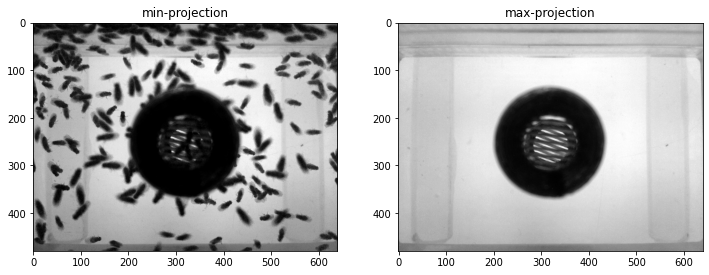

In [41]:
import matplotlib.pyplot as plt

# compute min and max projections
im_all_min = np.min(im_all, axis=0)
im_all_max = np.max(im_all, axis=0)

# display results with matplotlib
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(im_all_min, cmap='gray')
ax[0].set_title('min projection')
ax[1].imshow(im_all_max, cmap='gray')
ax[1].set_title('max projection')
plt.show()

---
### <span style="color:SteelBlue"> Exercice 2

In this exercice you will compute the median projection of "*im_all*" and subtract it to "*im_all*" itself.  
You will then display the result for the first image using matplotlib.  
- Hint #1: use `np.median` and `np.subtract` functions.  
- Hint #2: do not modify the "*im_all*" variable as we will use it later.

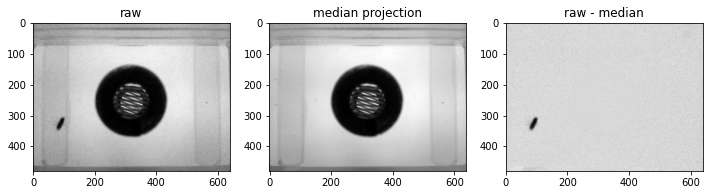

In [61]:
# Correction

# compute median projection
im_all_median = np.median(im_all, axis=0)

# subtract median projection from raw images
im_all_sub = np.subtract(im_all, im_all_median)

# Display result for the first image in matplotlib
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
ax[0].imshow(im_all[0], cmap='gray')
ax[0].set_title('raw')
ax[1].imshow(im_all_median, cmap='gray')
ax[1].set_title('median projection')
ax[2].imshow(im_all_sub[0], cmap='gray')
ax[2].set_title('raw - median')
plt.show()

For convinience, invert the subtracted images to make fly pixels brighter than the backgorund. 

In [64]:
from skimage.util import invert
im_all_sub = invert(im_all_sub)

Check the result with matplotlib:

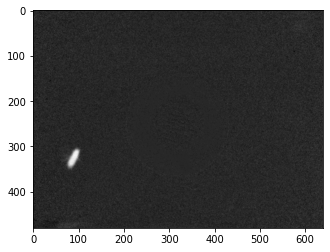

In [66]:
plt.imshow(im_all_sub[0], cmap='gray')
plt.show()

---
The next step will consists of separating pixels belonging to flies from those belonging to the background.  
In this case, we will simply apply a threshold (based on pixel intensity) to the subtracted images. 

**3.2)** Threshold subtracted images using the `threshold_yen` function.

In [ ]:
from skimage.util import invert
from skimage.filters import yen
fig, ax = try_all_threshold(invert(im_all_sub[0]), figsize=(8, 8))
plt.show()